In [1]:
import tensorflow as tf
from tensorflow import keras

### 简单的多层感知机
- 和softmax回归唯一的不同在于，我们多加了一个全连接层作为隐藏层。它的隐藏单元个数为256，并使用ReLU函数作为激活函数。

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(256, activation='relu',),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [5]:
# fashion_mnist = keras.datasets.fashion_mnist
# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# x_train = x_train / 255.0
# x_test = x_test / 255.0

In [8]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.5),
             loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.fit(x_train, y_train,
          epochs=5,
          batch_size=256,
          validation_data = (x_test,y_test),
          validation_freq = 1)

### 简单的线性分类器

In [9]:
from matplotlib import pyplot as plt
import random

In [28]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = tf.random.normal((num_examples, num_inputs), stddev = 1)
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += tf.random.normal(labels.shape,stddev=0.01)

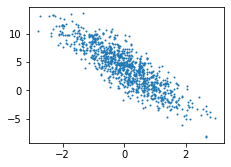

In [12]:
def set_figsize(figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
plt.scatter(features[:, 1], labels, 1)

## 写模型不可缺少的步骤和实现方式,以手动构建线性回归举例

### 1.读取数据
- 在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。

In [14]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = indices[i:min(i+batch_size,num_examples)]
        yield tf.gather(features, axis=0, indices=j), tf.gather(labels, axis=0, indices=j)

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [15]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tf.Tensor(
[[-1.0009625  -1.0014906 ]
 [-0.92488134 -0.08524901]
 [ 1.2781938  -0.8333126 ]
 [-0.63596976 -0.80683005]
 [-1.0557224  -0.36221355]
 [ 1.8000348   1.6206416 ]
 [ 0.06235145  0.60999733]
 [-0.9459097   0.65752953]
 [-1.3117768   0.10646594]
 [ 0.3443827  -1.061503  ]], shape=(10, 2), dtype=float32) tf.Tensor(
[5.6033945  2.63592    9.59115    5.6887155  3.3222578  2.3041556
 2.240062   0.07481673 1.1997888  8.486421  ], shape=(10,), dtype=float32)


### 2.初始化模型参数
- 我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [16]:
w = tf.Variable(tf.random.normal((num_inputs, 1), stddev=0.01))
b = tf.Variable(tf.zeros((1,)))

### 3.定义模型

In [19]:
def linreg(x,w,b):
    return tf.matmul(x,w) + b

### 4.定义损失函数

In [20]:
def squared_loss(y_hat, y):
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 /2

### 5.定义优化算法
- 以下的sgd函数实现了小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [26]:
def sgd(params, lr, batch_size, grads):
    """Mini-batch stochastic gradient descent."""
    for i, param in enumerate(params):
        param.assign_sub(lr * grads[i]/batch_size)#不改变内存地址上进行更新

### 6.训练模型
- 在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征X和标签y），通过调用反向函数t.gradients计算小批量随机梯度，并调用优化算法sgd迭代模型参数。由于我们之前设批量大小batch_size为10，每个小批量的损失l的形状为(10, 1)。回忆一下自动求梯度一节。由于变量l并不是一个标量，所以我们可以调用reduce_sum()将其求和得到一个标量，再运行t.gradients得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

- 在一个迭代周期（epoch）中，我们将完整遍历一遍data_iter函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。

In [27]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as t:
            t.watch([w,b])
            l = tf.reduce_sum(loss(net(X, w, b), y))
        grads = t.gradient(l, [w, b])
        sgd([w, b], lr, batch_size, grads)
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, tf.reduce_mean(train_l)))

epoch 1, loss 0.000050
epoch 2, loss 0.000050
epoch 3, loss 0.000050


## 线性回归的简洁实现

### 1.生成数据集

In [29]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = tf.random.normal(shape=(num_examples, num_inputs), stddev=1)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += tf.random.normal(labels.shape, stddev=0.01)

### 2.读取数据

In [31]:
from tensorflow import data as tfdata
#(features, labels)  type: tf.Tensor
batch_size = 10
#将训练数据和标签组合
dataset = tfdata.Dataset.from_tensor_slices((features, labels))
#随机读取小批量
dataset = dataset.shuffle(buffer_size=num_examples)
dataset = dataset.batch(batch_size)
#shuffle 的 buffer_size 参数应大于等于样本数，batch 可以指定 batch_size 的分割大小。
data_iter = iter(dataset)

In [32]:
for X, y in data_iter:
    print(X, y)
    break

tf.Tensor(
[[-0.2529511  -1.2222093 ]
 [-1.488042   -0.22310701]
 [ 1.910724   -0.07537813]
 [-0.68146527  0.5619334 ]
 [ 0.02452954  1.169147  ]
 [-0.08022968 -1.157499  ]
 [ 1.6391851   0.795107  ]
 [ 2.4685452  -0.01579604]
 [-0.6259472  -0.11549472]
 [ 0.37320036  1.964596  ]], shape=(10, 2), dtype=float32) tf.Tensor(
[ 7.8532033   1.9714571   8.282044    0.9179813   0.27707317  7.968178
  4.78043     9.176874    3.3433754  -1.7412081 ], shape=(10,), dtype=float32)


使用iter(dataset)的方式，只能遍历数据集一次，是一种比较 tricky 的写法，为了复刻原书表达才这样写。这里也给出一种在官方文档中推荐的写法：

In [33]:
for (batch, (X, y)) in enumerate(dataset):
    print(X, y)
    break

tf.Tensor(
[[ 0.5757189   0.13524647]
 [-2.1819665  -1.3438616 ]
 [-1.2079039   0.72684574]
 [ 0.48520005 -1.42077   ]
 [ 1.1616789   0.99253273]
 [-1.6202601   1.5013831 ]
 [-0.50778884  0.7078269 ]
 [-0.57310194 -0.2932425 ]
 [-0.2513959   1.8250375 ]
 [-1.4601657  -0.49996945]], shape=(10, 2), dtype=float32) tf.Tensor(
[ 4.876295   4.413867  -0.7000281 10.007149   3.1335862 -4.1454635
  0.8011116  4.0598497 -2.5145519  2.9777775], shape=(10,), dtype=float32)


### 3.定义模型和初始化参数
- Tensorflow 2.0推荐使用Keras定义网络，故使用Keras定义网络 我们先定义一个模型变量model，它是一个Sequential实例。 在Keras中，Sequential实例可以看作是一个串联各个层的容器。

- 在构造模型时，我们在该容器中依次添加层。 当给定输入数据时，容器中的每一层将依次推断下一层的输入尺寸。 重要的一点是，在Keras中我们无须指定每一层输入的形状。 线性回归，输入层与输出层等效为一层全连接层keras.layers.Dense()。

- Keras 中初始化参数由 kernel_initializer 和 bias_initializer 选项分别设置权重和偏置的初始化方式。我们从 tensorflow 导入 initializers 模块，指定权重参数每个元素将在初始化时随机采样于均值为0、标准差为0.01的正态分布。偏差参数默认会初始化为零。RandomNormal(stddev=0.01)指定权重参数每个元素将在初始化时随机采样于均值为0、标准差为0.01的正态分布。偏差参数默认会初始化为零。

In [35]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import initializers as init
model = keras.models.Sequential([
    layers.Dense(1, kernel_initializer=init.RandomNormal(stddev=0.01))
])

### 4.定义损失函数
- Tensoflow在losses模块中提供了各种损失函数和自定义损失函数的基类，并直接使用它的均方误差损失作为模型的损失函数。

In [36]:
from tensorflow import losses
loss = losses.MeanSquaredError()

### 5.定义优化算法
- 同样，我们也无须自己实现小批量随机梯度下降算法。tensorflow.keras.optimizers 模块提供了很多常用的优化算法比如SGD、Adam和RMSProp等。下面我们创建一个用于优化model 所有参数的优化器实例，并指定学习率为0.03的小批量随机梯度下降（SGD）为优化算法。

In [37]:
from tensorflow.keras import optimizers
trainer = optimizers.SGD(learning_rate=0.03)

### 6.训练模型
- Tensorflow训练模型时，我们通过调用tensorflow.GradientTape记录动态图梯度，执行tape.gradient获得动态图中各变量梯度。通过 model.trainable_variables 找到需要更新的变量，并用 trainer.apply_gradients 更新权重，完成一步训练。

In [38]:
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for (batch, (x,y)) in enumerate(dataset):
        with tf.GradientTape() as tape:
            out = model(x,training=True)
            l = loss(out,y)
        grads = tape.gradient(l, model.trainable_variables)#计算梯度
        trainer.apply_gradients(zip(grads, model.trainable_variables))#更新权重
        
    l = loss(model(features),labels)
    print('epoch %d, loss: %f' % (epoch, l))

epoch 1, loss: 0.000203
epoch 2, loss: 0.000104
epoch 3, loss: 0.000103


下面我们分别比较学到的模型参数和真实的模型参数。我们可以通过model的get_weights()来获得其权重（weight）和偏差（bias）。学到的参数和真实的参数很接近。